In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
cd '/content/gdrive/My Drive/VIP_Project/'

/content/gdrive/My Drive/VIP_Project


# Load Dataset

In [4]:
num_epoch = 100
batch_size = 1000

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

# prepare data
data = np.load( "moving-shapes-2-tr-images.npy" )

# training set
#x_tr = data[:5000,in_timesteps]
#y_tr = data[:5000,out_timesteps]
#tr_set = data[0:5000, :, :, :]

# validation set
x_te = data[5000:6000,in_timesteps]
y_te = data[5000:6000,out_timesteps]
te_set = data[5000:6000, :, :, :]

#print (np.shape(x_tr), np.shape(y_tr), np.shape(x_te), np.shape(y_te))
print (np.shape(x_te), np.shape(y_te))

(1000, 19, 64, 64, 3) (1000, 19, 64, 64, 3)


# Define Parameters

In [5]:
lstm_units = 1024
feature_vector = 1024
latent_dim = 256

# placeholders to hold each frame
x_ = tf.placeholder("float", shape= (None, len(in_timesteps),  64, 64, 3))
y_ = tf.placeholder("float", shape= (None, len(out_timesteps), 64, 64, 3))

# encoder
encoder_conv1_w = tf.get_variable("encoder_conv1_w", shape=[7, 7, 3, 16])
encoder_conv2_w = tf.get_variable("encoder_conv2_w", shape=[5, 5, 16, 32])
encoder_conv3_w = tf.get_variable("encoder_conv3_w", shape=[5, 5, 32, 48])
encoder_conv4_w = tf.get_variable("encoder_conv4_w", shape=[3, 3, 48, 64])

encoder_conv1_b = tf.get_variable("encoder_conv1_b", shape=[16])
encoder_conv2_b = tf.get_variable("encoder_conv2_b", shape=[32])
encoder_conv3_b = tf.get_variable("encoder_conv3_b", shape=[48])
encoder_conv4_b = tf.get_variable("encoder_conv4_b", shape=[64])

def encoder(x):
    out = tf.nn.conv2d(input=x,   filter=encoder_conv1_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv1_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv2_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv2_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv3_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv3_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d(input=out, filter=encoder_conv4_w, strides=[1, 2, 2, 1], padding='SAME') + encoder_conv4_b
    out = tf.nn.relu(out)
    out = tf.reshape(out, shape=[-1, 4*4*64])
    return out

# decoder
decoder_conv1_w = tf.get_variable("decoder_conv1_w", shape=[3, 3, 48, 64])
decoder_conv2_w = tf.get_variable("decoder_conv2_w", shape=[5, 5, 32, 48])
decoder_conv3_w = tf.get_variable("decoder_conv3_w", shape=[5, 5, 16, 32])
decoder_conv4_w = tf.get_variable("decoder_conv4_w", shape=[7, 7, 3, 16])

decoder_conv1_b = tf.get_variable("decoder_conv1_b", shape=[48])
decoder_conv2_b = tf.get_variable("decoder_conv2_b", shape=[32])
decoder_conv3_b = tf.get_variable("decoder_conv3_b", shape=[16])
decoder_conv4_b = tf.get_variable("decoder_conv4_b", shape=[3])

def decoder(x):
    out = tf.reshape(x, shape=[-1, 4, 4, 64])
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv1_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 8, 8, 48], padding='SAME') + decoder_conv1_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv2_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 16, 16, 32], padding='SAME') + decoder_conv2_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv3_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 32, 32, 16], padding='SAME') + decoder_conv3_b
    out = tf.nn.relu(out)
    out = tf.nn.conv2d_transpose(out, filter=decoder_conv4_w, strides=[1, 2, 2, 1], output_shape=[batch_size, 64, 64, 3], padding='SAME') + decoder_conv4_b
    out = tf.nn.sigmoid(out)
    return out

# f_posterior
f_posterior_fc1_w = tf.get_variable("phi_enc_fc1_w", shape=[feature_vector+lstm_units, latent_dim])
f_posterior_fc2_w = tf.get_variable("phi_enc_fc2_w", shape=[latent_dim, latent_dim])

f_posterior_fc1_b = tf.get_variable("phi_enc_fc1_b", shape=[latent_dim])
f_posterior_fc2_b = tf.get_variable("phi_enc_fc2_b", shape=[latent_dim])

f_posterior_mu_w = tf.get_variable("phi_enc_mu_w", shape=[latent_dim, latent_dim])
f_posterior_mu_b = tf.get_variable("phi_enc_mu_b", shape=[latent_dim])

f_posterior_sigma_w = tf.get_variable("phi_enc_sigma_w", shape=[latent_dim, latent_dim])
f_posterior_sigma_b = tf.get_variable("phi_enc_sigma_b", shape=[latent_dim])

def f_posterior(out):
    out = tf.matmul(out, f_posterior_fc1_w) + f_posterior_fc1_b    
    out = tf.nn.relu(out)
    out = tf.matmul(out, f_posterior_fc2_w) + f_posterior_fc2_b
    out = tf.nn.relu(out)
    
    out_mu  = tf.matmul(out, f_posterior_mu_w)  + f_posterior_mu_b
    out_std = tf.nn.softplus(tf.matmul(out, f_posterior_sigma_w) + f_posterior_sigma_b)
    
    return out_mu, out_std

# f_decoder
f_decoder_fc1_w = tf.get_variable("phi_dec_fc1_w", shape=[latent_dim+lstm_units, feature_vector])
f_decoder_fc2_w = tf.get_variable("phi_dec_fc2_w", shape=[feature_vector, feature_vector])

f_decoder_fc1_b = tf.get_variable("phi_dec_fc1_b", shape=[feature_vector])
f_decoder_fc2_b = tf.get_variable("phi_dec_fc2_b", shape=[feature_vector])

def f_decoder(out):
    out = tf.matmul(out, f_decoder_fc1_w) + f_decoder_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, f_decoder_fc2_w) + f_decoder_fc2_b
    out = tf.nn.relu(out)
        
    return out

# f_z
f_z_fc1_w = tf.get_variable("phi_z_fc1_w", shape=[latent_dim, latent_dim])
f_z_fc2_w = tf.get_variable("phi_z_fc2_w", shape=[latent_dim, latent_dim])

f_z_fc1_b = tf.get_variable("phi_z_fc1_b", shape=[latent_dim])
f_z_fc2_b = tf.get_variable("phi_z_fc2_b", shape=[latent_dim])

def f_z(out):
    out = tf.matmul(out, f_z_fc1_w) + f_z_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, f_z_fc2_w) + f_z_fc2_b
    out = tf.nn.relu(out)
    return out

# f_prior
f_prior_fc1_w = tf.get_variable("phi_prior_fc1_w", shape=[lstm_units, latent_dim])
f_prior_fc2_w = tf.get_variable("phi_prior_fc2_w", shape=[latent_dim, latent_dim])

f_prior_fc1_b = tf.get_variable("phi_prior_fc1_b", shape=[latent_dim])
f_prior_fc2_b = tf.get_variable("phi_prior_fc2_b", shape=[latent_dim])

f_prior_mu_w = tf.get_variable("phi_prior_mu_w", shape=[latent_dim, latent_dim])
f_prior_std_w = tf.get_variable("phi_prior_std_w", shape=[latent_dim, latent_dim])

f_prior_mu_b = tf.get_variable("phi_prior_mu_b", shape=[latent_dim])
f_prior_std_b = tf.get_variable("phi_prior_std_b", shape=[latent_dim])

def f_prior(out):
    out = tf.matmul(out, f_prior_fc1_w) + f_prior_fc1_b
    out = tf.nn.relu(out)
    out = tf.matmul(out, f_prior_fc2_w) + f_prior_fc2_b
    out = tf.nn.relu(out)
    
    out_mu  = tf.matmul(out, f_prior_mu_w)  + f_prior_mu_b
    out_std = tf.nn.softplus(tf.matmul(out, f_prior_std_w) + f_prior_std_b)
    
    return out_mu, out_std

def tf_kl_gaussgauss(mu_1, sigma_1, mu_2, sigma_2):
    return tf.reduce_sum(tf.log(sigma_2) - tf.log(sigma_1) + (sigma_1**2 + (mu_1 - mu_2)**2) / (2*((sigma_2)**2)) - 0.5, axis=1)

def cross_entropy(y_prediction, y):
    prediction_loss = y * tf.log(1e-10 + y_prediction) + (1 - y) * tf.log(1e-10 + 1 - y_prediction)
    return -tf.reduce_sum(prediction_loss, axis=[1, 2, 3])   

def batch_data(source, target, batch_size):

   # Shuffle data
    shuffle_indices = np.random.permutation(np.arange(len(target)))
    source = source[shuffle_indices]
    target = target[shuffle_indices]

    for batch_i in range(0, len(source)//batch_size):
        start_i = batch_i * batch_size
        source_batch = source[start_i:start_i + batch_size]
        target_batch = target[start_i:start_i + batch_size]

        yield np.array(source_batch), np.array(target_batch)

# lstm
lstm  = tf.nn.rnn_cell.LSTMCell(num_units = lstm_units, state_is_tuple=True)
lstm_state = lstm.zero_state(batch_size, tf.float32)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


# Define Architecture

In [6]:
y_hat_list = []
    
for i in range(0,len(in_timesteps)):
    
    # encode image
    encoder_out = encoder(tf.divide(x=x_[:,i,:,:,:],y=255.0))

    # compute prior
    f_prior_out_mu, f_prior_out_sigma = f_prior(lstm_state[1])
    
    # sample from prior 
    z = f_prior_out_mu + f_prior_out_sigma * tf.random_normal(shape=[256], mean=0.0, stddev=1.0)        
    f_z_out = f_z(z)

    # decode [lstm, latent information]
    f_decoder_out = f_decoder(tf.concat(values=(lstm_state[1], f_z_out), axis=1)) 
    y_hat = decoder(f_decoder_out)
    
    # append output
    y_hat_list.append(y_hat)
    
    # lstm state transition
    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(encoder_out, f_z_out), axis=1), state = lstm_state)

for i in range(len(in_timesteps),20):  
    
    # encode image
    encoder_out = encoder(y_hat)

    # compute prior
    f_prior_out_mu, f_prior_out_sigma = f_prior(lstm_state[1])
    
    # sample from prior 
    z = f_prior_out_mu + f_prior_out_sigma * tf.random_normal(shape=[256], mean=0.0, stddev=1.0)        
    f_z_out = f_z(z)

    # decode [lstm, latent information]
    f_decoder_out = f_decoder(tf.concat(values=(lstm_state[1], f_z_out), axis=1)) 
    y_hat = decoder(f_decoder_out)
    
    # append output
    y_hat_list.append(y_hat)
    
    # lstm state transition
    lstm_out, lstm_state = lstm(inputs = tf.concat(values=(encoder_out, f_z_out), axis=1), state = lstm_state)

y_hat_out = tf.transpose(tf.stack(y_hat_list), [1, 0, 2, 3, 4])

Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Load trained model

In [7]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "epoch-100")

INFO:tensorflow:Restoring parameters from epoch-100


# Tests

# Validation Set

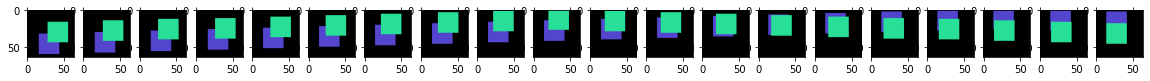

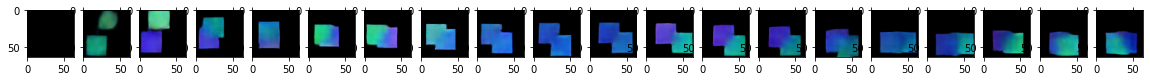

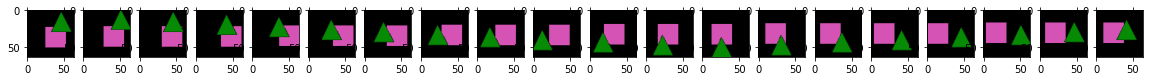

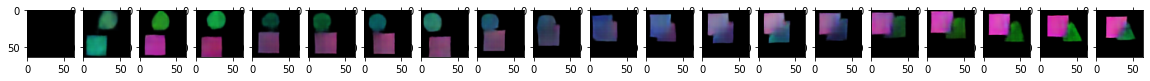

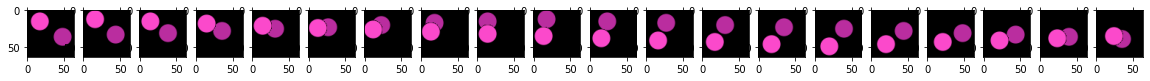

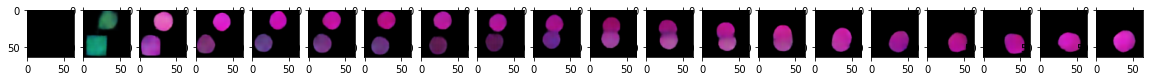

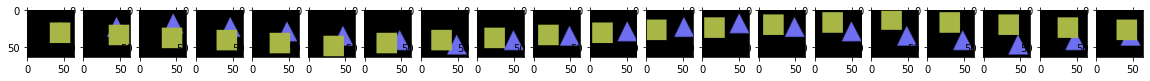

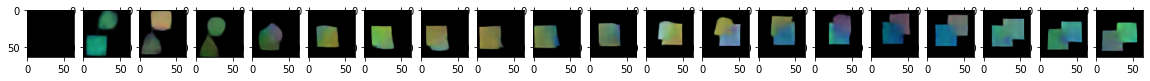

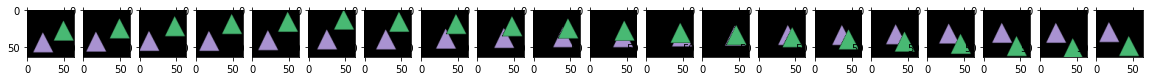

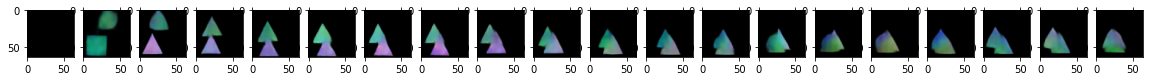

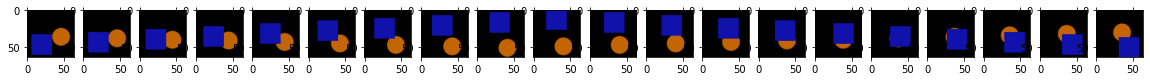

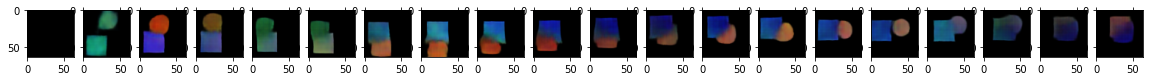

In [12]:
# Run
y_prediction = sess.run(y_hat_out, feed_dict={x_: x_te[0:batch_size,in_timesteps,:,:,:]})

# Show results
for sequence in range(1,7,1):
    
    # ground truth
    plt.figure(figsize=(20,10))
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(te_set[sequence,i,:,:])

    # prediction
    plt.figure(figsize=(20,10))
    plt.subplot(1,20,1)
    plt.imshow(np.zeros((64,64,3)))
    for i in range(19):
        plt.subplot(1, 20, i+2) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[sequence,i,:,:])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float32

te_set = img_as_float32(te_set)

mse=0
mae=0
ssim_v=0

for i in range(batch_size):
  mse_i=0
  mae_i=0
  ssim_i=0
  for j in range(19):
    mse_total=0
    mae_total=0
    ssim_total=0
    for k in range(3):
      mse_total += mean_squared_error(te_set[i,j+1,:,:,k],y_prediction[i,j,:,:,k])
      mae_total += mean_absolute_error(te_set[i,j+1,:,:,k],y_prediction[i,j,:,:,k])
      ssim_total += ssim(te_set[i,j+1,:,:,k],y_prediction[i,j,:,:,k],data_range=y_prediction[i,j,:,:,k].max() - y_prediction[i,j,:,:,k].min())
    mse_i += mse_total/3
    mae_i += mae_total/3
    ssim_i += ssim_total/3

  mse += mse_i
  mae += mae_i
  ssim_v += ssim_i

mse = mse/(batch_size*19)
mae = mae/(batch_size*19)
ssim_v = ssim_v/(batch_size*19)

print('MSE: ',mse)
print('MAE: ',mae)
print('SSIM: ',ssim_v)

MSE:  0.07072319435193798
MAE:  0.13515139129043874
SSIM:  0.3987879147867372
